In [1]:
import sys#TylerK: Add sys to get cmdline_helper from NRPy top directory; remove this line and next when debugged
sys.path.append('../')

import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface

# Create C code output directory:
Ccodesdir = "SEOBNR_Playground_Pycodes"

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spint
import Hamiltonian.Hreal_and_csi_on_bottom as hr
import Derivatives.hamiltonian_first_derivatives as dh
import Flux.flux as fl
import Flux.factorized_waveform_for_flux as wf


# Tutorial - Right-Hand-Side's for Hamilton's Equation of Motion for SEOBNR Models

In this notebook, we will implement the right hand side functions for the Hamilton's EOMs so that we can integrate them to get the trajectory. Since we are using scipy's ODE integration functionality, we will be writing these as wrappers that will ultimately be passed into the scipy functions.

To begin, we will recap the ODEs that form the Hamilton's EOMs and document the individual terms. We then create the wrapper function that will pass the phase space variables and parameters to the derivative functions generated before.

## Step : Hamilton's EOMs for SEOBNR implementations

The Hamilton's EOMs for a general SEOBNR implementation is given in https://arxiv.org/pdf/0912.3466.pdf as a set of derivatives for the positions, momenta and spins.
We begin by stating the positional derivatives as

$$
\frac{dX^i}{dt} = T^i_j \frac{\partial \mathcal{H}_\rm{real}}{\partial P^*_j}
$$

where $P^*$ represent the tortoise momenta and the matrix $\mathbb{T}$ represents the transformation matrix from the tortoise momentum to the conjugate momentum. The momentum derivatives, on the other hand, are given as

$$
\frac{dP^*_i}{dt} = -T_i^j\frac{\partial \mathcal{H}_\rm{real}}{\partial X^j} + \frac{1}{\Omega L }\frac{dE}{dt}P^*_j + P^*_l\left(T^{-1}\right)_k^l\frac{\partial T_i^k}{\partial X^j}T_m^j\frac{\partial \mathcal{H}_\rm{real}}{\partial P^*_m} 
$$

where $\Omega$ is the rotational frequency, $L$ is the magnitude of the angular momentum and $\frac{dE}{dt}$ is the energy flux due ot gravitational waves. Since we already have dedicate functions to compute the Hamiltonian derivates and the fluxes, in this notebook we will document the terms unique to the RHS computations and call the dedicated functions as necessary.

Finally, the spin derivatives are given as (where $a$ labels the individual spin vectors so $a \in \{1,2\}$)

$$
\dot{\bf{S}}\bf{_a} = \{\bf{S_a},\mathcal{H}\} = \frac{\partial \mathcal{H}}{\partial \bf{S_a}}\times\bf{S_a}
$$


### The Angular Momentum Magnitude $L$

The magnitude of the angular momentum vector is defined as follows

$$
L = \sqrt{\bf{L}\cdot\bf{L}}
$$

### The Angular Momentum Vector $\bf{L}$

The angular momentum vector has its usual definition and is defined using the tortoise momentum due to (Eq.A1 of PRD 81, 084041 (2010))

$$
\bf{L} = \bf{X}\times\bf{P} = \bf{X}\times\bf{P^*}
$$

### The Rotational Frequence $\Omega$

The rotational frequency is defined here as

$$
\Omega = \frac{1}{R^2}\sqrt{\bf{X}\times\dot{\bf{X}}}
$$

Where $R$ is the radial distance and $\dot{\bf{X}}$ is computed as the first set of right hand sides.


### The Positional Derivatives $\dot{\bf{X}}$

The derivatives of the coordinates are given as:

$$
\frac{dX^i}{dt} = T^i_j \frac{\partial \mathcal{H}_\rm{real}}{\partial P^*_j}
$$

### The $\mathbb{T}$ matrix

The trnasformation matrix from tortoise to conjugate momentum are given as

$$
T_i^j = \delta_{ij} + \frac{X^iX^j}{R^2}\left[\xi_a - 1\right]
$$

while the inverse matrix is given as

$$
\left(T^{-1}\right)_i^j = \delta_{ij} - \frac{\xi_a - 1}{\xi_a}\frac{X^iX^j}{R^2} 
$$

and the derivative of the matrix is given as

$$
\frac{\partial T_i^j}{\partial X^k} = \frac{\delta_{ik}X^j + X^i\delta_{jk}}{R^2}\left(\xi_a - 1\right) - 2\frac{X^iX^jX^k}{R^4}\left(\xi_a - 1\right) + \frac{X^iX^j}{R^2}\frac{\partial\xi_a}{\partial X^k} 
$$

Where, $\xi_a$ is the tortoise factor defined below and $R$ is the radial distance

### The Radial Distance $R$

The radial distance $R$ is given as usual

$$
R = \sqrt{\bf{X}\cdot\bf{X}}
$$


In [2]:
## question for developer:
# in the appendix of Pan2010, the flux term is multiplied by pstar but in lal it is multiplied by p. Why so?

def SEOBNR_RHS(t,var,m1,m2,tortoise):
    
    ## Unwrap all arguments
    eta = m1*m2/(m1+m2)/(m1+m2)
    q = np.array([var[0], var[1], var[2]])
    p = np.array([var[3], var[4], var[5]])
    S1 = np.array([var[6], var[7], var[8]])
    S2 = np.array([var[9], var[10], var[11]])
    
    ## Call necessary functions
    ham_and_potentials = hr.compute_Hreal_and_csi(m1,m2,EMGamma,tortoise,var[0],var[1],var[2],var[3],var[4],var[5],var[6],var[7],var[8],var[9],var[10],var[11])
    Hreal = ham_and_potentials[0]
    
    dHreal = dh.ham_first_derivs(m1,m2,tortoise,var[0],var[1],var[2],var[3],var[4],var[5],var[6],var[7],var[8],var[9],var[10],var[11])
    dHdX = np.array([dHreal[0],dHreal[1],dHreal[2]])/eta
    dHdP = np.array([dHreal[3],dHreal[4],dHreal[5]])/eta
    dHdS1 = np.array([dHreal[6],dHreal[7],dHreal[8]])
    dHdS2 = np.array([dHreal[9],dHreal[10],dHreal[11]])
    
    #for i in range(3):
    #    print("dHdP[%d] = %.16e"%(i,dHdP[i]))
    
    ## Compute R, R^-1 and R^-2
    
    R = np.linalg.norm(q)
    Rinv = 1/R
    R2inv = Rinv*Rinv
    
    ## Compute xi_a and xi_a - 1 and xi_a^-1
    
    xi_a = ham_and_potentials[1]
    xi_a_minusone = xi_a - 1
    xi_a_inv = 1/xi_a
    #print(xi_a)
    dxi_a = np.array([dHreal[12],dHreal[13],dHreal[14]])
    
    #print(dxi_a)
    ## Assign and Populate the Tortoise Matrix, its inverse, and its derivative
    
    kron_delta = lambda x,y: 1 if x== y else 0 
    
    T = np.zeros([3,3])
    Tinv = np.zeros([3,3])
    dT = np.zeros([3,3,3])
    
    ## T matrix has been validated
    for i in range(3):
        for j in range(3):
            T[i,j] = kron_delta(i,j) + q[i]*q[j]*xi_a_minusone*R2inv
            Tinv[i,j] = kron_delta(i,j) - q[i]*q[j]*xi_a_minusone*R2inv*xi_a_inv
    #for i in range(3):
    #    for j in range(3):
    #        print("T[%d,%d] = %.16e"%(i,j,T[i,j]))
            
    #for i in range(3):
    #    for j in range(3):
    #        print("Tinv[%d,%d] = %.16e"%(i,j,Tinv[i,j]))
                
    for i in range(3):
        for j in range(3):
            for k in range(3):
                dT[i,j,k] = ((kron_delta(i,k)*q[j] + q[i]*kron_delta(j,k) - 2*q[i]*q[j]*q[k]*R2inv)*xi_a_minusone + q[i]*q[j]*dxi_a[k])*R2inv 
    
    ## Compute the X derivatives
    
    dX = np.dot(T,dHdP)
    
    ## Compute Omega
    
    Omega = np.linalg.norm(np.cross(q,dX))*R2inv
    #print(Omega)
    
    ## Compute Angular Momentum and its magnitude, L
    
    Lvec = np.cross(q,p)
    L = np.linalg.norm(Lvec)
    
    ## Call the flux function to get dEdt
    
    dEdt = fl.compute_flux(m1,m2,tortoise,q,p,S1,S2,Omega,Hreal)
    #print(t,dEdt)
    ## Compute the S1, S2 derivatives
    
    dS1 = np.cross(dHdS1,S1)
    dS2 = np.cross(dHdS2,S2)
    
    ## Compute the terms in the momentum derivative and compute the P derivative
    
    Ham_deriv_term_1 = np.zeros(3)
    
    for i in range(3):
        Ham_deriv_term_1[i] = 0 
        for j in range(3):
            Ham_deriv_term_1[i] += T[i,j]*(-dHdX[j])
    
    Ham_deriv_term_2 = np.zeros(3)
    ## no nested loop, define individual terms
    #for i in range(3):
    #    for j in range(3):
    #        for k in range(3):
    #            for l in range(3):
    #                for m in range(3):
    #                    Ham_deriv_term_2[i] += p[l]*Tinv[l,k]*dT[k,i,j]*T[j,m]*dHdP[m]
    
    Ham_deriv_term_2_T11 = np.zeros([3,3,3])
    Ham_deriv_term_2_T12 = np.zeros([3,3])
    Ham_deriv_term_2_T2 = np.zeros([3])
    
    for i in range(3):
        for j in range(3):
            for l in range(3):
                for k in range(3):
                    Ham_deriv_term_2_T11[i,j,l] += dT[i,k,j]*Tinv[k,l]
    
    for i in range(3):
        for j in range(3):
            for k in range(3):
                Ham_deriv_term_2_T12[i,j] += Ham_deriv_term_2_T11[i,j,k]*p[k]
    
    for i in range(3):
        for j in range(3):
            Ham_deriv_term_2_T2[i] += dHdP[j]*T[i,j]
    
    for i in range(3):
        for j in range(3):
            Ham_deriv_term_2[i] += Ham_deriv_term_2_T12[i,j]*Ham_deriv_term_2_T2[j]
                
    pstar = np.zeros(3)
    for i in range(3):
        for j in range(3):
            pstar[i] += T[i,j]*p[j]
    
    flux_term = -p*dEdt/Omega/L/eta
    if (0):
        print("\n\n printing values \n\n")
        print(var)
        print("\n\n dHdX, T, Momentum Term 1:\n\n")
        print(dHdX)
        print(T)
        print(Ham_deriv_term_1)
        print("\n\n Tinv, dT, dHdP, Momentum Term 2:\n\n")
        print(Tinv)
        print("\n")
        print(dT)
        print("\n")
        print(dHdP)
        print(Ham_deriv_term_2)
        print("\n\n DEdt, flux_term: \n \n")
        print(dEdt/eta)
        print(flux_term)        
    
    dP = Ham_deriv_term_1 + Ham_deriv_term_2 + flux_term
    ## Return the values in the right order dX,dP,dS1,dS2
    
    return np.array([dX[0],dX[1],dX[2],dP[0],dP[1],dP[2],dS1[0],dS1[1],dS1[2],dS2[0],dS2[1],dS2[2]])


## Testing the RHS with the Initial Conditions

Here, we will plug into the RHS routine the initial conditions obtained from LALSuite in order to check if the function yields the correct right hand sides

In [3]:
lal_init_params = {'m1': 2.3000000000000000e+01, 'm2': 2.3000000000000000e+01, 'x': 1.7074619310971148e+01, 'y': 0.0000000000000000e+00, 'z': 0.0000000000000000e+00, 'S1x':  2.5000000000000001e-03, 'S1y': -4.9999999999999984e-03, 'S1z': -7.4999999999999997e-03, 'S2x': 1.0000000000000001e-01, 'S2y': -1.2500000000000001e-02, 'S2z': 1.5000000000000001e-02, 'p1': -8.1031960448995819e-04, 'p2': 2.6570593470494086e-01, 'p3': -2.2379305118219833e-04,'tortoise': 1}
m1 = lal_init_params['m1']
m2 = lal_init_params['m2']
eta = m1*m2/(m1+m2)/(m1+m2)
Cartesianderivatives = np.array([-7.4372569706908668e-04,2.4307375667449735e-01,1.4756359553280453e-10,-3.7825690120400707e-03,-3.8542164835667761e-06,1.8559418985917006e-05,3.8584811595798732e-06,2.2203029875074901e-06,-1.9404160514503526e-07,9.7410831950694998e-06,7.7030273133600846e-05,-7.4866035579596088e-07,-5.2113451210616946e-09,1.4235974532096679e-02])
Cartesianderivativespert = np.array([-7.4454573322703279e-04,2.4310747703608343e-01,-2.3061848435273547e-11,-3.7829767995429236e-03,-4.0460694927307497e-06,2.2564582971818183e-06,3.8565740230520171e-06,1.9729606035738584e-06,-2.9782394698566840e-08,9.7366413974785400e-06,7.6872717575104034e-06,-8.5034467060355696e-08,6.6468244710321533e-09,1.4235962728866914e-02])
MomentumTerm1 = [ -1.3088497326736192e-03 , -3.3404908468999864e-08 , 5.8397731095283234e-11 ]
MomentumTerm2 = [ -4.4936867757153234e-05 , 3.3645070075027284e-08 , -9.2124371138343366e-18 ]
FluxTerm = [ 3.2505033652576827e-10 , -4.4904787419519459e-07 , 1.6898324103064858e-14]
dEdt = 2.7469013978683326e-07
def SDA(x1,x2):
    erel = abs((x1 - x2)/(0.5*(x1 + x2)))
    if (x1 == x2):
        return 1000
    return int(-np.log10(erel) + 1)
EMGamma = 0.577215664901532860606512090082402431
tortoise = lal_init_params['tortoise']
lal_init_conditions = np.array([lal_init_params['x'], lal_init_params['y'], lal_init_params['z'], lal_init_params['p1'], lal_init_params['p2'], lal_init_params['p3'], lal_init_params['S1x'], lal_init_params['S1y'], lal_init_params['S1z'], lal_init_params['S2x'], lal_init_params['S2y'], lal_init_params['S2z']])
rhs_first_step = SEOBNR_RHS(0,lal_init_conditions,m1,m2,tortoise)
Cderivatives = [-7.4372569499148253e-04,2.4307375666377112e-01,1.4970668125991029e-10,-3.7825646555424081e-03,-8.9443344855631944e-07,1.8558171188461018e-05,3.8584811624132890e-06,2.2203029803489445e-06,-1.9404159942819939e-07,9.7410831986000941e-06,7.7030273148626601e-05,-7.4866036681179546e-07]
print("\n")
for i in range(12):
    sdanrpyc = SDA(rhs_first_step[i],Cderivatives[i])
    sdanrpylal = SDA(rhs_first_step[i],Cartesianderivatives[i])
    sdaclal = SDA(Cderivatives[i],Cartesianderivatives[i])
    allowed = SDA(Cartesianderivatives[i],Cartesianderivativespert[i])
    print("dvalues[%d] (lal , nrpy , c , sda(nrpy - c) , (sda nrpy - lal) , sda(c - lal) , allowed) = %.16e , %.16e , %.16e , %d , %d , %d , %d"%(i,Cartesianderivatives[i],rhs_first_step[i],Cderivatives[i],sdanrpyc,sdanrpylal,sdaclal,allowed))



dvalues[0] (lal , nrpy , c , sda(nrpy - c) , (sda nrpy - lal) , sda(c - lal) , allowed) = -7.4372569706908668e-04 , -7.4372569499148232e-04 , -7.4372569499148253e-04 , 16 , 9 , 9 , 3
dvalues[1] (lal , nrpy , c , sda(nrpy - c) , (sda nrpy - lal) , sda(c - lal) , allowed) = 2.4307375667449735e-01 , 2.4307375666377112e-01 , 2.4307375666377112e-01 , 1000 , 11 , 11 , 4
dvalues[2] (lal , nrpy , c , sda(nrpy - c) , (sda nrpy - lal) , sda(c - lal) , allowed) = 1.4756359553280453e-10 , 1.4970668146461932e-10 , 1.4970668125991029e-10 , 9 , 2 , 2 , 0
dvalues[3] (lal , nrpy , c , sda(nrpy - c) , (sda nrpy - lal) , sda(c - lal) , allowed) = -3.7825690120400707e-03 , -3.7825646555703597e-03 , -3.7825646555424081e-03 , 12 , 6 , 6 , 4
dvalues[4] (lal , nrpy , c , sda(nrpy - c) , (sda nrpy - lal) , sda(c - lal) , allowed) = -3.8542164835667761e-06 , -8.9442428304859127e-07 , -8.9443344855631944e-07 , 5 , 0 , 0 , 2
dvalues[5] (lal , nrpy , c , sda(nrpy - c) , (sda nrpy - lal) , sda(c - lal) , allowed)

In [4]:
## print out tortoise to make sure all inputs are consistent
## toggle the inputs to see which terms are problematic

In [5]:
#def Euler_Step(t,var,m1,m2,EMGamma,tortoise,h):
#    f = SEOBNR_RHS(t,var,m1,m2,EMGamma,tortoise)
#    return h*f

C:\Users\sidmahesh\anaconda3\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  warn("The following arguments have no effect for a chosen solver: {}."


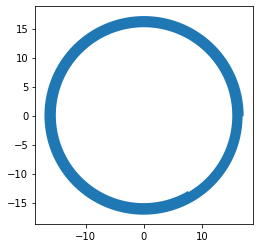

In [6]:
## simply ported final initial conditions from our lal solver

EMGamma = 0.577215664901532860606512090082402431
var_init = np.array([ 1.7077661371325462e+01, 0.0000000000000000e+00, 0.0000000000000000e+00, -7.1946742122340718e-04, 2.6577885496497711e-01, 4.0197262449583424e-18, 0.0000000000000000e+00, 0.0000000000000000e+00, 2.5000000000000001e-03, 0.0000000000000000e+00, 0.0000000000000000e+00, 2.5000000000000001e-03])
params = (23,23,1)
m1 = params[0]
m2 = params[1]
eta = m1*m2/(m1+m2)/(m1+m2)
max_time = 4000.

result = spint.solve_ivp(SEOBNR_RHS,(0,max_time),var_init,method = 'DOP853',dense_output=True,args = params,rtol = 1e-8, atol = 1e-8, min_step = 8e-5)

#result = SEOBNR_RHS(0,var_init,m1,m2,EMGamma,1)
dt = 1
time_series = np.arange(0.,max_time,dt)
#print(time_series)

sparse_array = result.y
dense_sol = result.sol.__call__(time_series)

plot_array = np.array([dense_sol[:,i] for i in range(len(time_series))])

plt.plot(plot_array[:,0],plot_array[:,1])
plt.axis('square')
plt.savefig('inspiraltrajectoryv4p.png',dpi = 300)


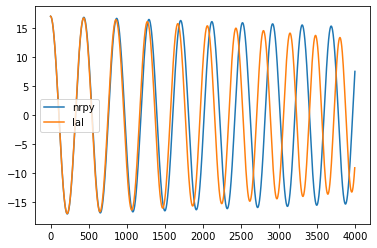

In [7]:
## upload trajectory from lalsuite
## inputs ./lalsimulation/bin/lalsim-inspiral -a SEOBNRv4P -f 20 -M 23 -m 23 -X 0.01 -Y -0.02 -Z -0.03 -x 0.40 -y -0.05 -z 0.06
## perturbed -a SEOBNRv4P -f 20 -M 23.000000000000023 -m 23 -X 0.01000000000000001 -Y -0.02 -Z -0.03 -x 0.40 -y -0.05 -z 0.06

laltrajectory = np.loadtxt("equalmassprec23.txt")
lalperttrajectory = np.loadtxt("equalmassprec23pert.txt")
## upload c trajectory
ctrajectory = np.loadtxt("output.txt")
## find the 4000M stop point

t4000index = np.argmin(np.abs(laltrajectory[:,0] - 4000.))

## compute the absolute error
dx = np.array([np.abs(lalperttrajectory[i,1] - laltrajectory[i,1]) for i in range(t4000index)])
## compare x values

#plt.plot(ctrajectory[:,0],ctrajectory[:,1])
plt.plot(time_series,plot_array[:,0],label = "nrpy")
plt.plot(laltrajectory[:t4000index,0],laltrajectory[:t4000index,1],label = "lal")
plt.fill_between(laltrajectory[:t4000index,0],laltrajectory[:t4000index,1] - dx,laltrajectory[:t4000index,1]+dx)
plt.legend()
plt.savefig("comparexvalues.png")
plt.show()

In [8]:
# get waveform amplitudes

amplitudes = []
for i in range(len(dense_sol[0])):
    #eta = params[0]*params[1]/(params[0] + params[1])/(params[0] + params[1])
    q = np.array([dense_sol[0,i],dense_sol[1,i],dense_sol[2,i]])
    p = np.array([dense_sol[3,i],dense_sol[4,i],dense_sol[5,i]])
    S1 = np.array([dense_sol[6,i],dense_sol[7,i],dense_sol[8,i]])
    S2 = np.array([dense_sol[9,i],dense_sol[10,i],dense_sol[11,i]])
    tortoise = 1
    ham_and_potentials = hr.compute_Hreal_and_csi(m1,m2,EMGamma,tortoise,q[0],q[1],q[2],p[0],p[1],p[2],S1[0],S1[1],S1[2],S2[0],S2[1],S2[2])
    Hreal = ham_and_potentials[0]
    
    dHreal = dh.ham_first_derivs(m1,m2,tortoise,q[0],q[1],q[2],p[0],p[1],p[2],S1[0],S1[1],S1[2],S2[0],S2[1],S2[2])
    dHdP = np.array([dHreal[3],dHreal[4],dHreal[5]])/eta
    
    #for i in range(3):
    #    print("dHdP[%d] = %.16e"%(i,dHdP[i]))
    
    ## Compute R, R^-1 and R^-2
    
    R = np.linalg.norm(q)
    Rinv = 1/R
    R2inv = Rinv*Rinv
    
    ## Compute xi_a and xi_a - 1 and xi_a^-1
    
    xi_a = ham_and_potentials[1]
    xi_a_minusone = xi_a - 1
    xi_a_inv = 1/xi_a
    #print(xi_a)
    dxi_a = np.array([dHreal[12],dHreal[13],dHreal[14]])
    
    #print(dxi_a)
    ## Assign and Populate the Tortoise Matrix, its inverse, and its derivative
    
    kron_delta = lambda x,y: 1 if x== y else 0 
    
    T = np.zeros([3,3])
    
    ## T matrix has been validated
    for i in range(3):
        for j in range(3):
            T[i,j] = kron_delta(i,j) + q[i]*q[j]*xi_a_minusone*R2inv
    
    ## Compute the X derivatives
    
    dX = np.dot(T,dHdP)
    
    ## Compute Omega
    
    Omega = np.linalg.norm(np.cross(q,dX))*R2inv
    v = np.cbrt(Omega)
    rcrossp = np.cross(q,p)
    rcrosspmag = np.linalg.norm(rcrossp)
    m1hat = m1/(m1+m2)
    m2hat = m2/(m1+m2)
    S1_over_m12 = S1/m1hat/m1hat
    S2_over_m22 = S2/m2hat/m2hat
    Lhat = rcrossp/rcrosspmag
    s1dotL = np.dot(S1_over_m12,Lhat)
    s2dotL = np.dot(S2_over_m22,Lhat)
    
    #print("s1dotL = ",s1dotL)
    #print("s2dotL = ",s2dotL)
    
    chiS = 0.5*(s1dotL + s2dotL)
    chiA = 0.5*(s1dotL - s2dotL)
    amplitudes.append(wf.compute_hFlm_for_flux(params[0], params[1], params[2], q, p, S1, S2, 2, 2, Hreal, v,chiA,chiS))



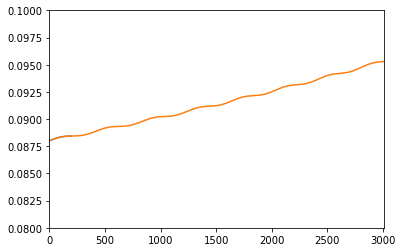

In [12]:
plt.plot(time_series[0:200],amplitudes[0:200])

#data = np.loadtxt("outputv4Pindex0.txt")
#datpert = np.loadtxt("outputv4Pindex0pert.txt")
#M = m1+m2
#t_M = M*4.93e-6
#t_data = (data[:,0] - data[0,0])/t_M
#t_data_pert = (datpert[:,0] - datpert[0,0])/(t_M*(1 + 1e-5))
#amp = np.array([np.sqrt(data[i,1]**2 + data[i,2]**2) for i in range(len(data))])
#amppert = np.array([np.sqrt(datpert[i,1]**2 + datpert[i,2]**2) for i in range(len(datpert))])
#amppert *= amplitudes[0]/amppert[0]
#amp *= amplitudes[0]/amp[0]
#plt.plot(t_data,amp)
plt.plot(time_series,amplitudes)
plt.xlim(0,3010)
plt.ylim(0.08,0.1)
plt.savefig("dt1.png")
plt.show()

In [ ]:
data = "outputv4Pindex0.txt"
#datapert = "outputv4Pindex0pert.txt"
LALvalues = []
LALvaluespert = []
eta = (m1*m2)/(m1+m2)/(m1+m2)

with open(data) as file, open(datapert) as filepert:
    data_lines = file.readlines()
    pertdata_lines = filepert.readlines()
    for i in range(len(data_lines)//2):
        valuepairs = data_lines[2*i].strip('{}\n').split(',')
        pertvaluepairs = pertdata_lines[2*i].strip('{}\n').split(',')
        values = dict()
        pertvalues = dict()
        #print(i)
        for j in range(len(valuepairs)):
            pair = valuepairs[j].split(': ')
            pertpair = pertvaluepairs[j].split(': ')
            #print(pertpair)
            values[pair[0].strip(" ''")] = float(pair[1])
            pertvalues[pertpair[0].strip(" ''")] = float(pertpair[1])
        LALvalues.append([values['x'],values['y']])
        LALvaluespert.append([pertvalues['x'],pertvalues['y']])


plt.plot(plot_array[:,0],plot_array[:,1])
LALvalues = np.array(LALvalues)
LALvaluespert = np.array(LALvaluespert)
plt.plot(LALvalues[:,0],LALvalues[:,1])
plt.plot(LALvaluespert[:,0],LALvaluespert[:,1])
plt.axis('square')




In [ ]:
plt.plot(plot_array[:,0],plot_array[:,1])
dt = 1
time_series = np.arange(0.,max_time,dt)
print(time_series)
sparse_array = result.y
dense_sol = result.sol.__call__(time_series)

plot_array = np.array([dense_sol[:,i] for i in range(len(time_series))])

LALvalues = np.array(LALvalues)
plt.plot(np.log10(np.abs((LALvalues[:,0] - plot_array[:,0])/LALvalues[:,0])))
plt.plot(np.log10(np.abs((LALvaluespert[:,0]- LALvalues[:,0])/LALvalues[:,0])))
plt.plot(LALvalues[:,0])
plt.plot(plot_array[:,0])

In [ ]:
plt.plot(LALvalues[:,1])
plt.plot(plot_array[:,1])

In [ ]:
plt.plot([np.linalg.norm([plot_array[i,0],plot_array[i,1]]) for i in range(len(plot_array))])
plt.plot([np.linalg.norm([LALvalues[i,0],LALvalues[i,1]]) for i in range(len(plot_array))])
